## Wavelet entropy in Julia: an introduction

*Note: this is a draft. I guarantee nothing* 

Kristian Agasøster Haaga, 08.12.2021.

Updates
- July 17th, 2023: 
    - Use `ComplexityMeasures` instead of `Entropies` (package has been renamed).
    - Add `Project.toml` file.

In [1]:
Pkg.activate("./");

  Activating project at `~/Code/Repos/Temp/waveletentropy_example`


In [2]:
using Statistics, ComplexityMeasures, Plots, Wavelets, LaTeXStrings

We'll start by generating a time series  $f(t), t \in [1, 2, \ldots , N]$, which, for plotting convenience, we limit to $N = 300$ points.

In [3]:
N, a = 300, 10
t = LinRange(0, 2*a*π, N)
f = sin.(rand(1:15, N) ./ rand(1:10, N));

## Maximal overlap discrete wavelet transform

A discrete wavelet transform is computed by sliding a particular type of wave filter across a time series signal $f(t)$, and seeing how well the filter matches the original signal at a particular point in time. It is computed using $W(\tau, s) = \dfrac{1}{\sqrt{s}} \sum_{t = 0}^{N-1} f(t) \phi \left( \dfrac{t - \tau}{s} \right)$, where $t$ is the time index, $\tau$ is a time-shift parameter (changing $\tau$ will shift the wavelet relative to the original signal), and $s$ governs the width of the wavelet ($s$ large yields wide/expanded wavelets, which match lower frequencies better; $s$ small yields narrow/shrunken wavelets which match higher frequencies better). The value $W(\tau, s)$ indicates how well the signal, at a particular time $\tau$, matches the wavelet whose width is $s$.

If $\tau = k 2^{-j}$ and $s = 2^{-j}$, we call the scales *dyadic scales*. Using dyadic scales requires relatively few computations to calculate wavelet coefficients $W(\tau, s)$. In constrast, if we wanted a continuous wavelet transform, computations would be more expensive, because we would need to compute the transform for a continous set of scaler and time-shifts (or, rather, with *small enough* steps, when using a computer).

To illustrate how wavelet entropy is computed, we'll first compute the detail coefficients for a maximal overlap discrete wavelet transform (MODWT), which assumes circular boundary conditions, so that there are $J$ coefficients for each time $t$. We will obtain a matrix $W_{t,s}$ with $N$ rows and $n_{scales}$ columns. Each row in $W$ contains the wavelet coefficients at time $t$ for scales $J = 1, 2, \ldots, n_{scales}$. There are `n_scales = Wavelets.WT.maxmodwttransformlevels(f) = floor(Int, log2(length(f))) = floor(Int, log2(N))` possible scales for our signal $f(t)$, and the number of scales will vary with signal length. 

In [4]:
Wavelets.WT.maxmodwttransformlevels(f), floor(Int, log2(N))

(8, 8)

There are many possible choices of the wavelet function $\phi(\tau, s)$. Here, we'll pick the Haar wavelet, because it has the property of additive decomposition (Percival & Walden, 2000, p. 205), which means that we can reconstruct the original time series from the wavelet coefficients.

In [5]:
wl = Wavelets.WT.Haar()
W = ComplexityMeasures.get_modwt(f, wl)

300×9 Matrix{Float64}:
  0.00249242   0.0261144    0.13728     …  0.0204394   0.0197763  0.507929
 -0.284499    -0.127323     0.0864345      0.014747    0.023818   0.505341
  0.329128    -0.118689     0.0698282      0.0182232   0.022111   0.507404
 -0.0723313    0.150712     0.0417943      0.0250938   0.0192257  0.509065
 -0.121157     0.0316537   -0.0898047      0.0155549   0.0224248  0.509761
 -0.0914501   -0.203048    -0.0144731   …  0.0350393   0.0261757  0.507535
 -0.476072    -0.390065    -0.222723       0.0184861   0.0247691  0.502548
  0.550608    -0.246494    -0.250939       0.0260809   0.0222336  0.501694
 -0.134561     0.245291    -0.251593       0.0212858   0.0168353  0.502297
  0.329283     0.305384    -0.195326       0.0450129   0.0161109  0.503132
  ⋮                                     ⋱                         
 -0.737079     0.144059    -0.426848       0.0206947   0.039105   0.492345
  0.541999    -0.322021    -0.132311       0.0181788   0.0311553  0.497369
  0.310895

Because of the property of additive decomposition, we can write $\mathbf{x} = \sum_{i=1}^{n_{scales}} \mathbf{W_i}$ (here $\mathbf{x}$ and $\mathbf{W_i}$ are column vectors, and $\mathbf{W_i}$ contain the coefficients at scale $i$). A single time series value at time $k$ can thus be reconstructed $\sum_{i = 1}^{n_{scales}} W_{k,i}$. Let's verify that our original signal and wavelet-reconstructed signal are equal (within some tolerance, due to imprecisions introduced during calculations):

In [6]:
reconstructed = [sum(W[t, :]) for t = 1:N]

all(f .- reconstructed .< 1e-10)

true

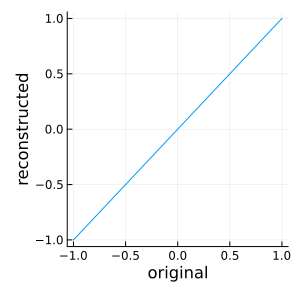

In [7]:
plot(f, reconstructed, size = (300, 300), label = "", xlabel = "original", ylabel = "reconstructed")

## Relation between original time series and coefficients

The detail coefficients at successive levels are the parts of the signals left by passing the original signal through successive low-pass filters, such that the coefficients at level $j$ contains the part of the time series whose frequencies did not pass further down the cascade of low-pass filters. The coefficients at dyadic scale $j$ corresponds to a frequency range $\big(\dfrac{1}{2^{j+1}}, \dfrac{1}{2^{j}}\big]$. Let's visualize this:

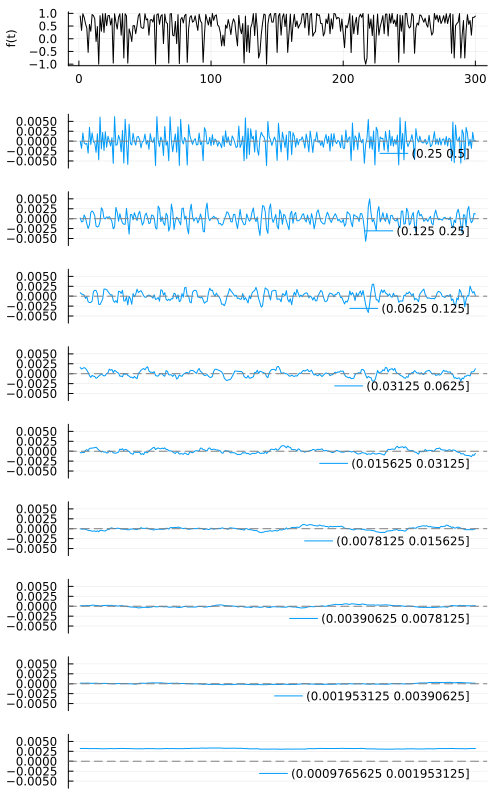

In [8]:
# Normalize coefficients to total energy to have the same axis scales, see below
Etot = sum(W .^ 2)
emax = maximum(W ./ Etot)*1.1

# Plot the coefficients for each dyadic scale j, corresponding to frequency range (1/2^(j+1), 1/2^j].
ps = Plots.Plot[]
for j = 1:size(W, 2)
    ylbl = "s_$j"
    lbl = string("(", 1/2^(j+1), " ", 1/2^j, "]")
    push!(ps, plot(W[:, j] ./ Etot, 
                    fg_legend = :transparent, bg_legend = :transparent, legend = :bottomright,
                    xticks = false, xaxis = false,
                    ylabel = latexstring(ylbl), label = lbl, ylim = (-emax, emax)))
    hline!([0], ls = :dash, label = "", lq = 0.8, c = :grey)
end

# Merge original plot and coefficient plots.
p_ts = plot(f, ylabel = "f(t)", xlabel = "t", c = :black, label = "")
p_wl = plot(p_ts, ps..., link = :x, layout = grid(length(ps)+1, 1), guidefont = font(8), size = (500, 800), xlabel = "")

For our example time series, we can see that most of the variability is located at intermediate-high frequencies.

## Relative signal energy and wavelet entropy

The [*energy*](https://en.wikipedia.org/wiki/Energy_(signal_processing)) of the signal at a particular scale level (frequency range) $j$ is $E_j = \sum_{t=1}^{N} (W_{tj})^2$. The total energy of the signal is $E_{tot} = \sum_{t=1}^{N}\sum_{j = 1}^{n_{scales}} (W_{t,j})^2$. Based on the quantities $E_j$ and $E_{tot}$, we can define the *relative energy* at each frequency range $\big(\dfrac{1}{2^{j+1}}, \dfrac{1}{2^{j}}\big]$ as $p_j = \dfrac{E_j}{E_{tot}}$.
The relative energy at level $j$ thus gives an indication of strongly that frequency range is present in the original signal. Normalizing each $p_j$ to the total energy, this naturally gives rise of the notion of a *probability distribution over the frequency bands corresponding to each dyadic levels*.  

In [9]:
ρs = [ComplexityMeasures.energy_at_scale(W, j) ./ Etot for j = 1:size(W, 2)]

9-element Vector{Float64}:
 0.28441694579490656
 0.12251987840145467
 0.06266915351670233
 0.02772296387446214
 0.013979899102641573
 0.008914974706103189
 0.002794900608798883
 0.0011771327328826775
 0.4758041512620484

Computing entropy from `ρs` is of course trivial:

In [10]:
entropy(Shannon(base = 2), Probabilities(ρs))

1.9726948423144322

Entropy is maximized for a uniform probability distribution, and is always lower for non-flat distributions.

In [11]:
h = Shannon(base = 2)
entropy(h, Probabilities([0.2, 0.2, 0.2, 0.2, 0.2])), entropy(h, Probabilities([0.1, 0.2, 0.3, 0.2, 0.2]))

(2.321928094887362, 2.2464393446710154)

Similarly, the wavelet entropy is maximized when energy is spread out across all frequency bands. The following three signals illustrate this nicely.

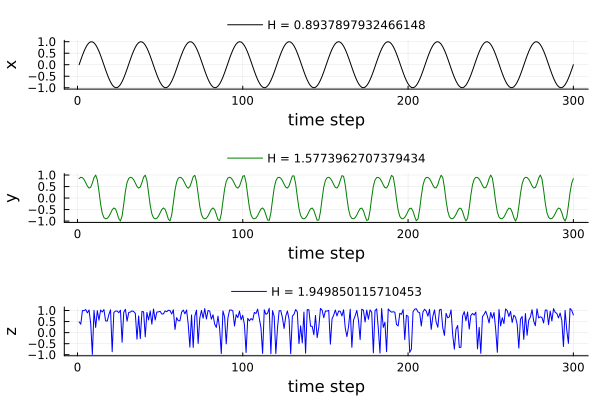

In [12]:
relative_wavelet_energies = ComplexityMeasures.relative_wavelet_energies
get_modwt = ComplexityMeasures.get_modwt
x = sin.(t);
y = sin.(t .+  cos.(t/0.5));
z = sin.(rand(1:15, N) ./ rand(1:10, N)) .+ rand(N)*0.1

est = TimeScaleMODWT()
h = Shannon(base = 2)
h_x = entropy(h,est, x)
h_y = entropy(h,est, y)
h_z = entropy(h,est, z)

px = plot(x, ylabel = "x", c = :black, label = "H = $(h_x)")
py = plot(y, ylabel = "y", c = :green, label = "H = $(h_y)")
pz = plot(z, ylabel = "z", c = :blue, label = "H = $(h_z)")

# Get coefficients, then compute relative energies corresponding to 
# different frequency bands.
wl = Wavelets.WT.Haar()
ρx = relative_wavelet_energies(get_modwt(x, wl))
ρy = relative_wavelet_energies(get_modwt(y, wl))
ρz = relative_wavelet_energies(get_modwt(z, wl))
# Or ComplexityMeasures.time_scale_density(ts, wl) directly

plot(px, py, pz, layout = grid(3, 1), xlabel = "time step", 
    legend = :outertop, fg_legend = :transparent, bg_legend = :transparent)

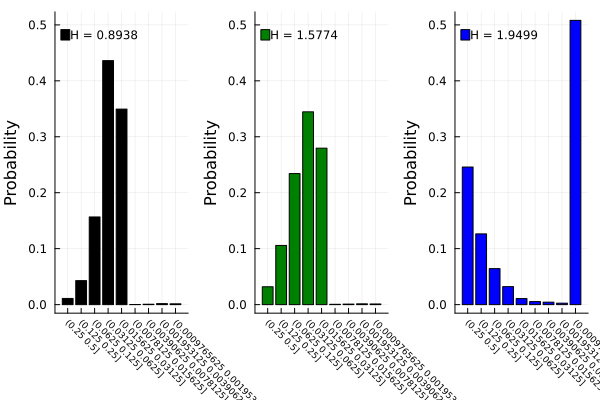

In [13]:
frequency_bands = [string("(", 1/2^(j+1), " ", 1/2^j, "]") for j = 1:length(ρx)]
distx = bar(ρx, c = :black, ylabel = "Probability", xticks = (1:length(ρx), frequency_bands), xrotation =-45, xtickfont = font(6), label = "H = $(round(h_x, digits = 4))")
disty = bar(ρy, c = :green, ylabel = "Probability", xticks = (1:length(ρx), frequency_bands), xrotation =-45, xtickfont = font(6), label = "H = $(round(h_y, digits = 4))")
distz = bar(ρz, c = :blue, ylabel = "Probability", xticks = (1:length(ρx), frequency_bands), xrotation =-45, xtickfont = font(6), label = "H = $(round(h_z, digits = 4))")
plot(distx, disty, distz, layout = grid(1, 3), link = :y, legend = :topleft, fg_legend = :transparent, bg_legend = :transparent)

The time series with the widest range of frequencies (`z`) has the highest wavelet entropy, while the smoothest time series (`x`) which has most of its energy at few frequency bands has the lowest wavelet entropy.